## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, regularizer, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regularizer)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
RATIO_INPUTS = [1e-2, 1e-4, 1e-8]
REGULARIZERS = ['L1', 'L1_L2']

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
def get_tag(reg_name, ratio):
    return "%s-%s" % (reg_name, str(ratio))

def fit(reg_name, regulizer_ratio):
    regularizer = None
    if reg_name == 'L1':
        regularizer = l1(regulizer_ratio)
    else:
        regularizer = l1_l2(regulizer_ratio)
    
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], regularizer=regularizer)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = get_tag(reg_name, ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

for reg_name in REGULARIZERS:
    for ratio in RATIO_INPUTS:
        fit(reg_name, ratio)

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 8s 165us/step - loss: 2.4626 - accuracy: 0.0973 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 162us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.7828 - accuracy: 0.6253 - val_loss: 3.1555 - val_accuracy: 0.4951
Epoch 47/50
50000/50000 [==============================] - 9s 174us/step - loss: 2.7500 - accuracy: 0.6234 - val_loss: 3.1107 - val_accuracy: 0.4924
Epoch 48/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.7068 - accuracy: 0.6272 - val_loss: 3.0228 - val_accuracy: 0.5104
Epoch 49/50
50000/50000 [==============================] - 9s 183us/step - loss: 2.6647 - accuracy: 0.6317 - val_loss: 2.9743 - val_accuracy: 0.5177
Epoch 50/50
50000/50000 [==============================] - 9s 186us/step - loss: 2.6346 - accuracy: 0.6322 - val_loss: 2.8897 - val_accuracy: 0.5331
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

50000/50000 [==============================] - 9s 176us/step - loss: 0.9514 - accuracy: 0.6649 - val_loss: 1.3759 - val_accuracy: 0.5314
Epoch 44/50
50000/50000 [==============================] - 9s 190us/step - loss: 0.9371 - accuracy: 0.6708 - val_loss: 1.4014 - val_accuracy: 0.5189
Epoch 45/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.9298 - accuracy: 0.6729 - val_loss: 1.3668 - val_accuracy: 0.5350
Epoch 46/50
50000/50000 [==============================] - 9s 177us/step - loss: 0.9134 - accuracy: 0.6785 - val_loss: 1.3689 - val_accuracy: 0.5318
Epoch 47/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.9062 - accuracy: 0.6812 - val_loss: 1.4025 - val_accuracy: 0.5235
Epoch 48/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.8894 - accuracy: 0.6870 - val_loss: 1.4679 - val_accuracy: 0.5237
Epoch 49/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.8768 - accuracy: 0.6929 - val_loss

50000/50000 [==============================] - 10s 201us/step - loss: 2.4616 - accuracy: 0.1000 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 10s 201us/step - loss: 2.4616 - accuracy: 0.0985 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 10s 205us/step - loss: 2.4615 - accuracy: 0.0989 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 10s 201us/step - loss: 2.4615 - accuracy: 0.0982 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 10s 201us/step - loss: 2.4615 - accuracy: 0.0976 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 10s 199us/step - loss: 2.4615 - accuracy: 0.0975 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 10s 201us/step - loss: 2.4614 - accuracy: 0.0968 - va

50000/50000 [==============================] - 10s 191us/step - loss: 1.8175 - accuracy: 0.4651 - val_loss: 1.8239 - val_accuracy: 0.4597
Epoch 38/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.8102 - accuracy: 0.4658 - val_loss: 1.8286 - val_accuracy: 0.4590
Epoch 39/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.8055 - accuracy: 0.4661 - val_loss: 1.8063 - val_accuracy: 0.4666
Epoch 40/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.7969 - accuracy: 0.4702 - val_loss: 1.8351 - val_accuracy: 0.4564
Epoch 41/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.7927 - accuracy: 0.4703 - val_loss: 1.8037 - val_accuracy: 0.4670
Epoch 42/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.7882 - accuracy: 0.4704 - val_loss: 1.7990 - val_accuracy: 0.4690
Epoch 43/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.7825 - accuracy: 0.4706 - va

50000/50000 [==============================] - 10s 201us/step - loss: 1.7209 - accuracy: 0.5023 - val_loss: 1.8041 - val_accuracy: 0.4624
Epoch 35/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.7064 - accuracy: 0.5040 - val_loss: 1.7401 - val_accuracy: 0.4866
Epoch 36/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.6963 - accuracy: 0.5063 - val_loss: 1.7445 - val_accuracy: 0.4820
Epoch 37/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.6824 - accuracy: 0.5087 - val_loss: 1.7349 - val_accuracy: 0.4820
Epoch 38/50
50000/50000 [==============================] - 10s 202us/step - loss: 1.6722 - accuracy: 0.5105 - val_loss: 1.7152 - val_accuracy: 0.4957
Epoch 39/50
50000/50000 [==============================] - 11s 210us/step - loss: 1.6662 - accuracy: 0.5121 - val_loss: 1.7084 - val_accuracy: 0.4927
Epoch 40/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.6574 - accuracy: 0.5139 - va

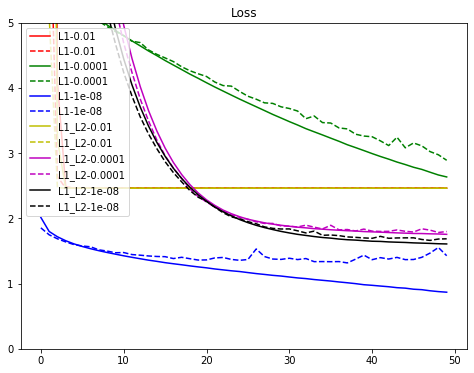

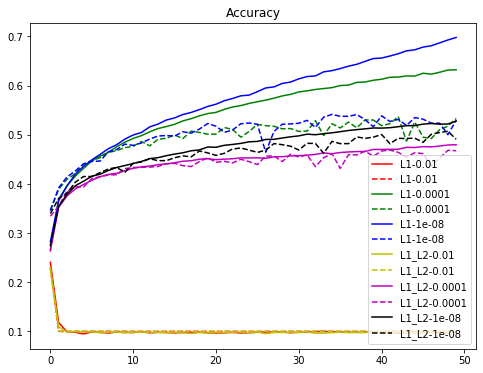

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()